In [19]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

### Problem 8
(a) Summarize the single linear regression:
- There is a linear relationship between 'mpg' and 'horsepower'
- The relationship is strongly negative
- The predicted value for 'horsepower' = 98 is 'mpg' = 24.46
- Confidence interval [23.97, 24.96], while prediction interval [14.80, 34.12]

(b) Plot the regression line

(c) Diagnostic plot
- Residual plot indicates a non-linear pattern
- Many data points have high leverage, causing sensitivity to model

In [7]:
Auto = load_data('Auto')
Auto.head(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1


In [24]:
X = pd.DataFrame({'intercept': np.ones(Auto.shape[0]), 'horsepower': Auto['horsepower']})
y = Auto['mpg']
model = sm.OLS(y, X)
result = model.fit()
summarize(result)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [26]:
X_new = pd.DataFrame({'intercept': 1, 'horsepower': [98]})
y_pred = result.get_prediction(X_new)
print(f'New prediction: {y_pred.predicted_mean}')
print(f'Confidence interval: \n{y_pred.conf_int(alpha=0.05)}')
print(f'Prediction interval: \n{y_pred.conf_int(obs=True, alpha=0.05)}')

New prediction: [24.46707715]
Confidence interval: 
[[23.97307896 24.96107534]]
Prediction interval: 
[[14.80939607 34.12475823]]


In [38]:
predictions = result.predict(X)
data = pd.DataFrame({'X': X['horsepower'], 'y': y, 'predictions': predictions})

scatter = go.Scatter(x=data['X'], y=data['y'], mode='markers', name='Data')
line = go.Scatter(x=data['X'], y=data['predictions'], mode='lines', name='Regression Line')

fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title='Regression Line and Data Points',
    xaxis_title='X',
    yaxis_title='y',
    width=1000,  
    height=400  
)
fig.show()


In [37]:
scatter = go.Scatter(x=result.fittedvalues, y=result.resid, mode='markers', name='Residual')
fig = go.Figure(data=[scatter])
fig.add_shape(type='line', x0=min(result.fittedvalues), y0=0, x1=max(result.fittedvalues), y1=0, 
    line=dict(color='black', dash='dash'))
fig.update_layout(
    title='Residual plot vs fitted values',
    xaxis_title='Fitted value',
    yaxis_title='Residual',
    width=1000,
    height=400
)
fig.show()


115

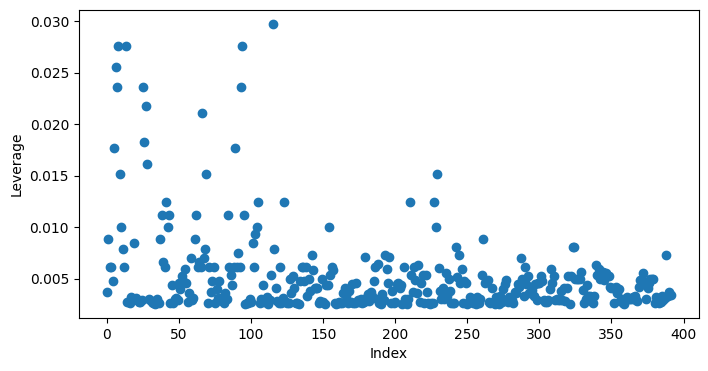

In [39]:
infl = result.get_influence()
ax = subplots(figsize=(8, 4))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

### Problem 9: